# Example Workflow with spatialproteomics and spatialdata
Welcome to spatialproteomics, the toolbox to analyze highly multiplexed fluorescence image data!

During the processing of such data, you will generate different data structures, which all share some common dimensions. For example, the multiplexed imaging data (channels, x, y) share spatial dimensions with their corresponding segmentation masks (x, y). Similarly, the instance labels in a segmentation mask can be viewed as a dimension that aligns with the expression matrix (cells, channels) quantifying protein expression for each cell. Therefore, a desirable data structure for multiplexed imaging data should keep such shared dimensions consistent, ensuring that changes to one component automatically update the others to maintain consistency. For example, when subsetting a region of an image, the segmentation mask should be subset accordingly, and the expression matrix should only retain cells within this region.

To enable all of this, the core functionality in `spatialproteomics` is based on `xarray`. The image below illustrates these concepts.

<p align="center" width="100%">
    <img src="../_static/img/supplementary_figure_1.png" alt="The spatialproteomics data structure enables synchronized subsetting across shared dimensions." style="width:50%;"/>
</p>


Recently, the `spatialdata` format has emerged as a popular alternative, promising standardized storage solution and hence better interoperability with other tools in the field. `Spatialproteomics` integrates with `spatialdata` in two ways:

1. If you want to use the full functionality of `spatialproteomics`, it is recommended that you use the `xarray` backend first (which is used in all tutorials but this one), and then export to `spatialdata` using `tl.convert_to_spatialdata()`. Refer to the FAQ for more information on this.

2. Alternatively, `spatialproteomics` also offers the possibility to work with `spatialdata` objects directly. The syntax for this closely resembles the one commonly used in `squidpy` and other tools which are part of the `scverse` ecosystem.

In this notebook, we will go through an example workflow that is fully based on this `spatialdata`-based backend. We will be looking at the following steps:

1. Reading in a highly multiplexed image and creating a spatialdata object

2. Performing basic image processing steps to boost the signal-to-noise ratio

3. Performing cell segmentation using _cellpose_

4. Quantifying protein expression per cell

5. Predicting cell types with a simple argmax technique

6. Plotting the results with spatialdata-plot

**Important:** In order to run `spatialproteomics` with the `spatialdata` backend, it is important that `spatialdata` is installed. You can either do this manually, or install `spatialproteomics` with the additional backend by using `pip install spatialproteomics[spatialdata]`.

In [1]:
%load_ext autoreload
%autoreload 2

import spatialproteomics as sp
import spatialdata as sd
import spatialdata_plot
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d
import pandas as pd
import numpy as np

/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## 1. Getting Started

Before we can get started with _spatialproteomics_, we first need to read in the image. You can do this using the `spatialdata-io` package. Alternatively, you can construct your own _spatialdata_ object from scratch, which is what we will do here.

In [2]:
# reading in the image and displaying its shape
image = imread("../../data/input.tiff")
image.shape

(5, 500, 500)

We can see that our image has 5 channels and has a size of 500 by 500 pixels. Next, we want to create a _spatialdata_ object and store the image within the object. To do this, we also need to feed in the names of the channels.

In [3]:
image = sd.models.Image2DModel.parse(
    image, transformations=None, dims=("c", "x", "y"), c_coords=["DAPI", "CD4", "CD8", "FOXP3", "BCL6"]
)
sdata = sd.SpatialData(images={"image": image})
sdata

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


SpatialData object
└── Images
      └── 'image': DataArray[cyx] (5, 500, 500)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images)

## 2. Image Processing
Highly multiplexed fluorescence imaging techniques frequently suffer from poor signal-to-noise ratio. To alleviate this problem, you can threshold out low intensity pixels, thereby boosting the contrast of the image. While there are automated methods to determine the thresholds for such operations, it is difficult to come up with one that works in all cases. Here, we therefore set the thresholds based on manual inspection. For more details, check the notebook on `Image Processing`.

Let's start by looking at the data set in the current form.

In [4]:
# setting the same colors as in the other notebook for consistency
colors = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4367858515955403].


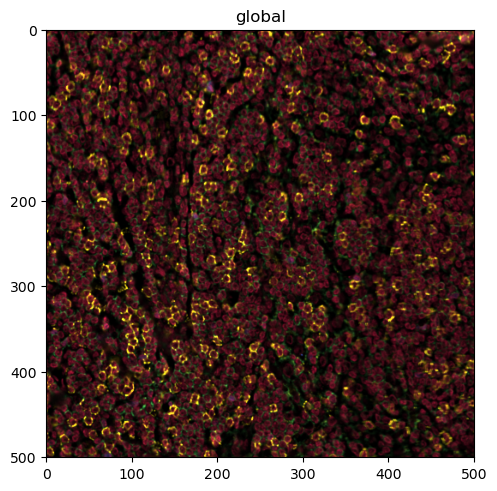

In [5]:
# here, we use the spatialdata-plot library for visualization
sdata.pl.render_images(palette=colors).pl.show()

This is a bit much to look at. First, we want to check only the DAPI channel, to get a feel for the signal-to-noise ratio.

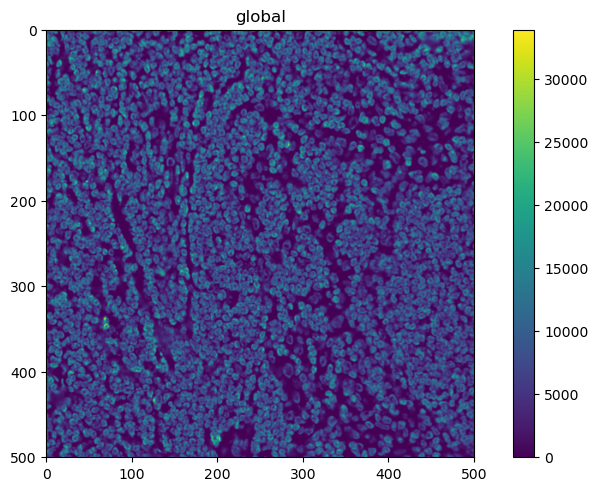

In [6]:
sdata.pl.render_images(channel="DAPI").pl.show()

This looks promising. What about the other channels?

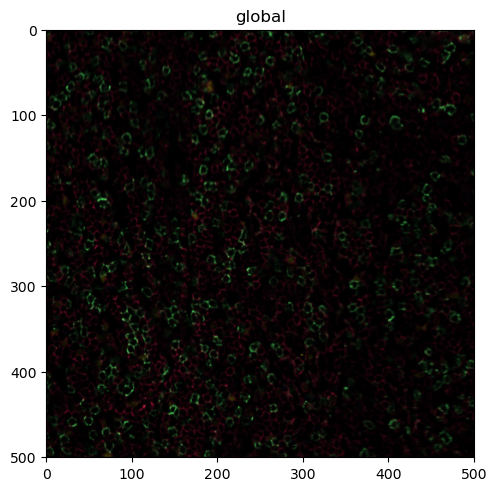

In [7]:
sdata.pl.render_images(channel=["CD4", "CD8", "FOXP3", "BCL6"], palette=colors[:-1]).pl.show()

Looking good, but we can make the signal a bit clearer by performing some image processing. In the following codeblock, we first threshold the channels by some percentile (so every value below that percentile gets set to 0). We then apply a 2D median filter with a kernel size of 3 to apply some smoothing.

In [8]:
# the percentiles by which the channels will be thresholded
percentiles = [0.2, 0.6, 0.6, 0.6, 0.6]

# thresholding and smoothing the data
# note that by default, this performs in-place operations, you can avoid this by setting copy=True in any of the methods
sp.pp.threshold(sdata, quantile=percentiles)
sp.pp.apply(sdata, medfilt2d, kernel_size=3)

INFO     `dims` is specified redundantly: found also inside `data`.                                                


/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:71: UserWarning: Key `image` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:71: UserWarning: Key `image` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Note that `spatialdata` warned us that the key `image` already exists and will be overwritten in memory. This is because by default, the operations on the `spatialdata` object are performed in-place to conserve memory. If you do not wish to perform operations in-place, you can simply set `copy=True` in any of the methods. This will keep the original object unaltered, and return a new, modified object instead.

Now that we got that out of the way, let's plot the new object.

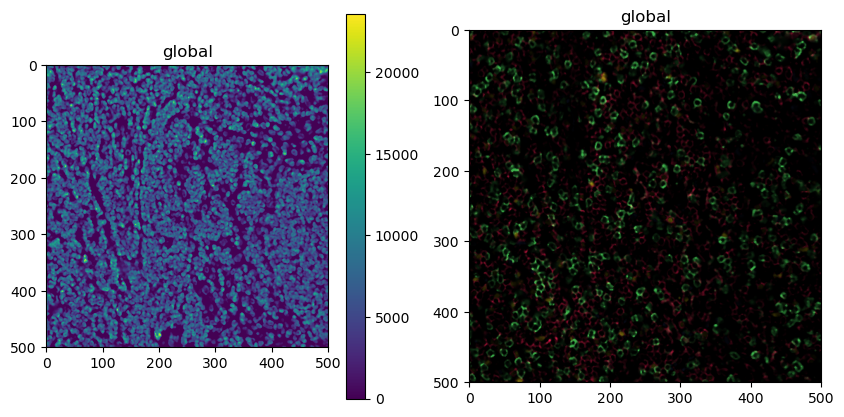

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sdata.pl.render_images(channel="DAPI").pl.show(ax=ax[0])
sdata.pl.render_images(channel=["CD4", "CD8", "FOXP3", "BCL6"], palette=colors[:-1]).pl.show(ax=ax[1])

## 3. Cell Segmentation

Great, this is our preprocessing done. Next, we can perform cell segmentation. Since we only have a universal nuclear marker at hand (and no universal membrane marker), we will segment the nuclei and then simply extend the segmentation masks by two pixels in every direction. We are going to use _cellpose_ for this purpose, which is implemented in the tool (tl) module. Note that this requires you to install cellpose first, for example by running `pip install cellpose` in your terminal.

In [10]:
sp.tl.cellpose(sdata, channel="DAPI")
sdata

Neither TORCH CUDA nor MPS version not installed/working.
>>>> using CPU
>>>> using CPU
>> cyto3 << model set to be used
>>>> loading model /home/meyerben/.cellpose/models/cyto3
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 11.45 sec
>>> diameter(s) = 
[ 10.22 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 26.38 sec


SpatialData object
├── Images
│     └── 'image': DataArray[cyx] (5, 500, 500)
└── Labels
      └── 'segmentation': DataArray[yx] (500, 500)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), segmentation (Labels)

Looking at the object, you will realize that a new layer called `segmentation` has appeared. We can plot this over the original image with `spatialdata-plot`. Let's also zoom in a little bit to get a clearer picture.

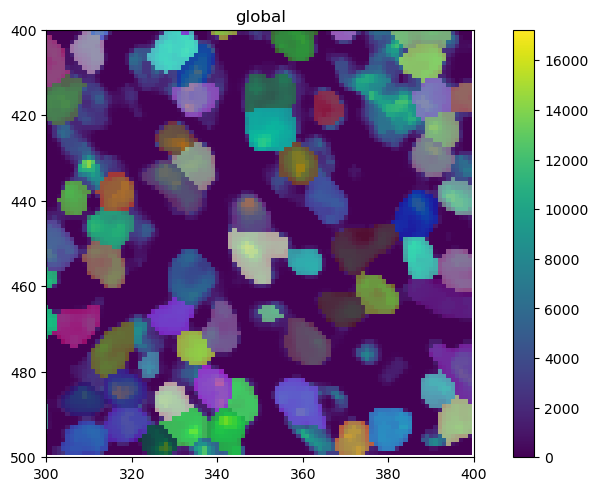

In [11]:
sdata_zoomed = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[300, 400],
    max_coordinate=[400, 500],
    target_coordinate_system="global",
)

sdata_zoomed.pl.render_images(channel=["DAPI"]).pl.render_labels().pl.show()

## 4. Quantifying Protein Expression per Cell
There are a couple of issues which can arise from segmentation. One is that sometimes very small cells get segmented, which are likely artifacts. We can hence filter cells that are too small or too big. In addition, we will grow the masks by two pixels in each direction to try to capture cytoplasm and membrane.

With the `spatialdata` backend, it is important that we first quantify the protein expression in each cell. There are multiple ways to do this, but taking the median intensity and then applying an arcsinh-transform has been proven to work pretty well.

In [12]:
sp.pp.add_quantification(sdata, func="intensity_mean")
sp.pp.transform_expression_matrix(sdata, method="arcsinh")
sdata

SpatialData object
├── Images
│     └── 'image': DataArray[cyx] (5, 500, 500)
├── Labels
│     └── 'segmentation': DataArray[yx] (500, 500)
└── Tables
      └── 'table': AnnData (1335, 5)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), segmentation (Labels)

As you can see, this introduced a new layer called `table`. This is an `anndata` object that contains the quantification of each protein for each cell.

In [13]:
sdata.tables["table"]

AnnData object with n_obs × n_vars = 1335 × 5
    obs: 'id', 'region'
    uns: 'spatialdata_attrs'

In [14]:
sp.pp.add_observations(sdata, "area")

In [15]:
# checking the obs slot in our anndata object
sdata.tables["table"].obs.head()

,id,region,area
Cell_1,1,segmentation,54.0
Cell_2,2,segmentation,33.0
Cell_3,3,segmentation,64.0
Cell_4,4,segmentation,67.0
Cell_5,5,segmentation,23.0


In [16]:
# filtering out cells with less than 20 or more than 150 pixels
sp.pp.filter_by_obs(sdata, "area", func=lambda x: (x > 20) & (x < 150))

/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:88: UserWarning: Key `segmentation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


After the filtering, you can see that there are less cells both in the segmentation mask as well as in the anndata object.

In [17]:
print(
    len(np.unique(sdata.labels["segmentation"].values)) - 1
)  # -1 because the background (0) is also counted otherwise
print(sdata.tables["table"])

1329
AnnData object with n_obs × n_vars = 1329 × 5
    obs: 'id', 'region', 'area'
    uns: 'spatialdata_attrs'


Let's also note down the average cell area before and after growing the masks.

In [18]:
sdata.tables["table"].obs["area"].values.mean()

63.308502633559065

In [19]:
# expanding the masks
sp.pp.grow_cells(sdata, iterations=2)
# adding the area back into the object
sp.pp.add_observations(sdata, "area")

Mask growing requires recalculation of the observations. All features will be removed and should be recalculated with pp.add_observations().


In [20]:
sdata.tables["table"].obs["area"].values.mean()

101.38525206922498

The average area has indeed increased. Let's also check what the new segmentation masks look like on top of DAPI or our other markers.

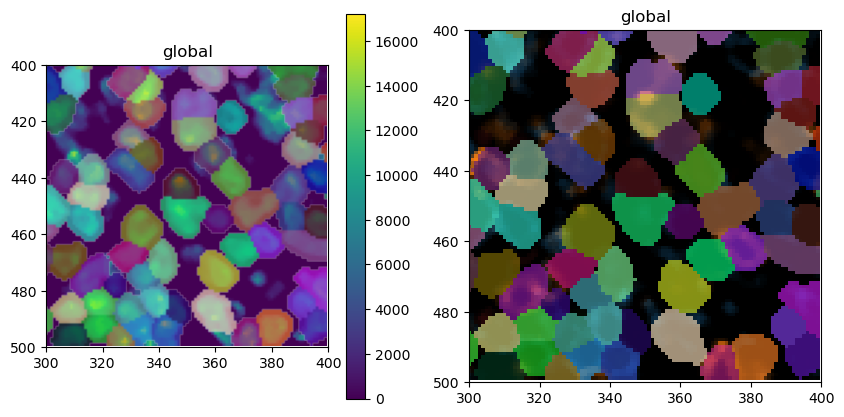

In [21]:
# plotting the resulting segmentation masks
sdata_zoomed = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[300, 400],
    max_coordinate=[400, 500],
    target_coordinate_system="global",
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sdata_zoomed.pl.render_images(channel=["DAPI"]).pl.render_labels().pl.show(ax=ax[0])
sdata_zoomed.pl.render_images(channel=["CD4", "CD8", "FOXP3", "BCL6"]).pl.render_labels().pl.show(ax=ax[1])

## 5. Cell Type Prediction
Finally, we can move on to cell type prediction. There are several ways to predict cell types. Since we thresholded our data beforehand, we can simply take the argmax of the cell type specific channels to get an idea of the cell types we are looking at. Methods related to cell type prediction are all implemented in the label (la) module.

In [22]:
# this dictionary maps from cell types to markers
marker_dict = {"CD4": "T_h", "CD8": "T_tox", "FOXP3": "T_reg", "BCL6": "T_fh"}
sp.la.predict_cell_types_argmax(sdata, marker_dict)

In [23]:
# checking what the "obs" in the anndata object look like
sdata.tables["table"].obs.head()

,id,region,area,celltype
Cell_1,1,segmentation,101.0,T_tox
Cell_2,2,segmentation,48.0,T_tox
Cell_3,3,segmentation,99.0,T_tox
Cell_4,4,segmentation,108.0,T_h
Cell_5,5,segmentation,42.0,T_h


As you can see, this added a column called `celltype` to our `anndata.obs`.

## 6. Plotting
Finally, let's do some plotting of the predicted cell types.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0553018069973088].
/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:771: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


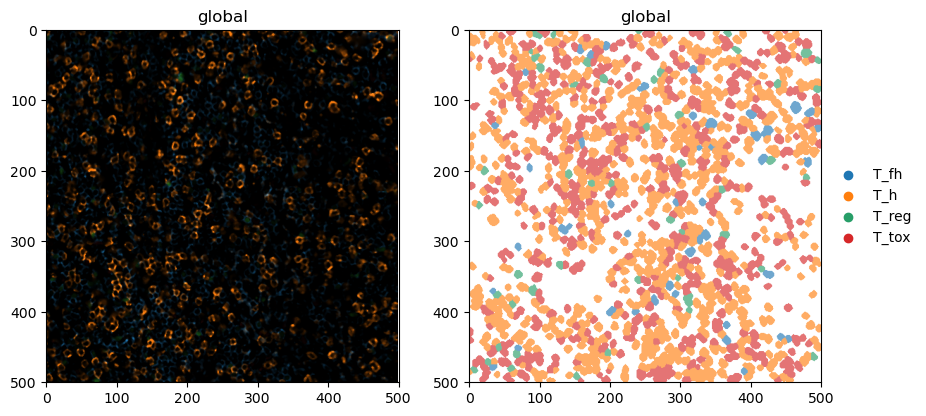

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sdata.pl.render_images(channel=["CD4", "CD8", "FOXP3", "BCL6"]).pl.show(ax=ax[0])
sdata.pl.render_labels(color="celltype").pl.show(ax=ax[1])

And this is how easy it can be to perform analysis of highly multiplexed immunofluorescence images! If you have any additional questions, check out the other notebooks for details.